### Data
This notebook contains all of the pre-processing and formatting necessary to generate training, validation, and test data.

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import george

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.optimize import minimize
from functools import partial

In [2]:
# Read data/metadata from csv files
df = pd.read_csv("data/training_set.csv")
md = pd.read_csv("data/training_set_metadata.csv")
df

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1
...,...,...,...,...,...,...
1421700,130779836,60555.9838,4,-39.881969,46.477093,0
1421701,130779836,60560.0459,1,14.894439,18.947685,0
1421702,130779836,60571.0225,5,30.593130,50.695290,0
1421703,130779836,60585.9974,4,-23.471439,44.819859,0


In [3]:
md

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,26.718750,-14.940303,172.342697,-72.255675,0,0.0000,0.0000,0.0000,NaN,0.013,65
7844,130755807,120.101349,-62.696659,275.742955,-16.509746,0,0.1725,2.5606,1.1146,46.6108,0.136,90
7845,130762946,203.108109,-55.682144,308.728904,6.727511,0,0.0000,0.0000,0.0000,NaN,0.430,16
7846,130772921,79.101562,-35.501846,239.172243,-33.827844,0,0.0000,0.0000,0.0000,NaN,0.034,65


#### Preprocessing

In [ ]:
# Remove all objects with less than 5 data points (there are none)
df = df.groupby("object_id").filter(lambda x: len(x) >= 5)

In [ ]:
# Remove all objects with a CSNR <= 10
removed_ids = []
for object_id in df["object_id"].unique():
    obj = df.loc[df["object_id"] == object_id]
    csnr = np.sqrt(np.sum((obj["flux"] ** 2) / (obj["flux_err"] ** 2)))
    if csnr <= 10:
        removed_ids.append(object_id)
removed_ids

In [ ]:
# Remove all objects with a timeframe < 30 days (there are none)
removed_ids = []
for object_id in df["object_id"].unique():
    obj = df.loc[df["object_id"] == object_id]
    start = obj["mjd"].iloc[0]
    end = obj["mjd"].iloc[-1]
    time = end - start
    if time < 30:
        removed_ids.append(object_id)
removed_ids

#### Sample Light Curve

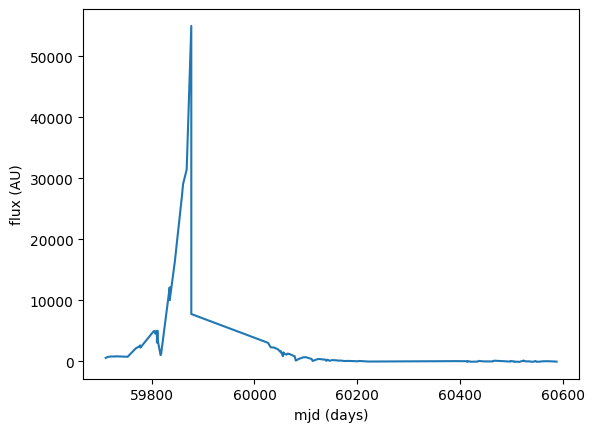

In [6]:
# Examine one particular object
obj = df.loc[df["object_id"] == 130779836]
plt.xlabel("mjd (days)")
plt.ylabel("flux (AU)")
plt.plot(obj["mjd"], obj["flux"])
plt.show()

#### 80/10/10 Train/Val/Test split

In [10]:
train_ids, val_test_ids = train_test_split(md["object_id"], test_size=0.2, random_state=39)
len(train_ids), len(val_test_ids)

(6278, 1570)

In [11]:
val_ids, test_ids = train_test_split(val_test_ids, test_size=0.5)
len(val_ids), len(test_ids)

(785, 785)

#### Class Distribution Analysis

In [12]:
train_md = md.loc[md["object_id"].isin(train_ids)]
len(train_md.loc[train_md["target"] == 90]) / len(train_md)

0.2945205479452055

In [13]:
val_md = md.loc[md["object_id"].isin(val_ids)]
len(val_md.loc[val_md["target"] == 90]) / len(val_md)

0.3006369426751592

In [14]:
test_md = md.loc[md["object_id"].isin(test_ids)]
len(test_md.loc[test_md["target"] == 90]) / len(test_md)

0.29044585987261146

Because this is a binary classification problem, we only have two classes. We want the training data to have a balanced class distribution (50% Type 1a, 50% non Type1a). Therefore, we will randomly discard training points such that there are an equal number of points from each class.

In [18]:
train_md_Ia = train_md.loc[train_md["target"] == 90]
train_md_nonIa = train_md.loc[train_md["target"] != 90]
train_md_nonIa = train_md_nonIa.sample(len(train_md_Ia))
train_ids = list(train_md_Ia["object_id"]) + list(train_md_nonIa["object_id"])
len(train_md_Ia), len(train_md_nonIa), len(train_ids)

(1849, 1849, 3698)

#### Helper functions for heatmap creation

In [55]:
def pb_to_wavelength(pb):
    """
    Converts LSST ugrizY passbands (0, 1, 2, 3, 4, 5) to wavelength using ugrizY
    """
    if pb == 0:
        return 3670.69
    if pb == 1:
        return 4826.85
    if pb == 2:
        return 6223.24
    if pb == 3:
        return 7545.98
    if pb == 4:
        return 8590.90
    if pb == 5:
        return 9710.28

def create_gp(obj, guess_length_scale=20, verbose=False):
    """
    Code is from https://github.com/kboone/avocado, some minor modifications
    """
    mjds = obj["mjd"]
    fluxes = obj["flux"]
    flux_errors = obj["flux_err"]
    wavelengths = [pb_to_wavelength(pb) for pb in obj["passband"]]
    
    signal_to_noises = np.abs(fluxes) / np.sqrt(flux_errors ** 2 + (1e-2 * np.max(fluxes)) ** 2)
    scale = np.abs(fluxes[signal_to_noises.idxmax()])
    
    kernel = (0.5 * scale) ** 2 * george.kernels.Matern32Kernel([guess_length_scale ** 2, 6000 ** 2], ndim=2)
    
    gp = george.GP(kernel)
    guess_parameters = gp.get_parameter_vector()
    
    if verbose:
        print(kernel.get_parameter_dict())
        
    x_data = np.vstack([mjds, wavelengths]).T

    gp.compute(x_data, flux_errors)

    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(fluxes)

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(fluxes)
    
    bounds = [(0, np.log(1000 ** 2))]
    bounds = [(guess_parameters[0] - 10, guess_parameters[0] + 10)] + bounds + [(None, None)]
    
    try:
        fit_result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like, bounds=bounds)
        if fit_result.success:
            gp.set_parameter_vector(fit_result.x)
    except ValueError:
        gp.set_parameter_vector(guess_parameters)
        
    if verbose:
        print(fit_result)
        print(kernel.get_parameter_dict())
        
    gaussian_process = partial(gp.predict, fluxes)
    return gaussian_process

def get_t_min_max(obj):
    index = np.argmax(obj["flux"])
    t_peak = obj["mjd"].iloc[index]
    
    t_min = t_peak - 50
    t_max = t_peak + 130
    return t_min, t_max

def create_heatmap(obj, mjd_bins=180, wavelength_bins=32, verbose=False):
    """
    Creates heatmap from original light curve using gaussian process regression
    """
    gp = create_gp(obj, verbose=verbose)
    if gp == None:
        print("Gaussian process was none")
        return
    
    t_min, t_max = get_t_min_max(obj)
    
    mjds = np.linspace(t_min, t_max, mjd_bins)
    wavelengths = np.linspace(3000.0, 10100.0, wavelength_bins)
    
    grid = np.transpose([np.tile(mjds, len(wavelengths)), np.repeat(wavelengths, len(mjds))])
    predictions, prediction_vars = gp(rid, return_var=True)
    predictions = np.array(predictions).reshape(32, 180)
    uncertainties = np.sqrt(prediction_vars).reshape(32, 180)
    
    min_flux = np.min(predictions)
    max_flux = np.max(predictions)
    
    min_uncertainty = np.min(uncertainties)
    max_uncertainty = np.max(uncertainties)
    
    if max_flux - min_flux == 0:
        normalized_predictions = predictions * 0
    else:
        normalized_predictions = (predictions - min_flux) / (max_flux - min_flux)
        
    if max_uncertainty - min_uncertainty == 0:
        normalized_uncertainties = uncertainties * 0
    else:
        normalized_uncertainties = (uncertainties - min_uncertainty) / (max_uncertainty - min_uncertainty)

    return normalized_predictions, normalized_uncertainties


#### Sample heatmaps

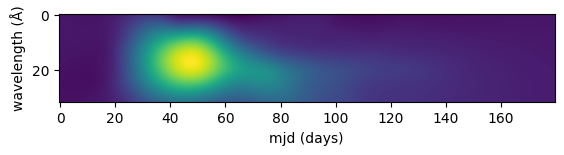

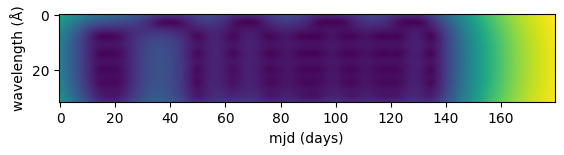

In [56]:
# Type 1a supernova
id = train_md_Ia["object_id"].iloc[4]
obj = df.loc[df["object_id"] == id]
pred, uncertainties = create_heatmap(obj)
plt.figure(0)
plt.xlabel("mjd (days)")
plt.ylabel("wavelength (Å)")
plt.imshow(pred, cmap="viridis", interpolation="gaussian")
plt.figure(1)
plt.xlabel("mjd (days)")
plt.ylabel("wavelength (Å)")
plt.imshow(uncertainties, cmap="viridis", interpolation="gaussian")

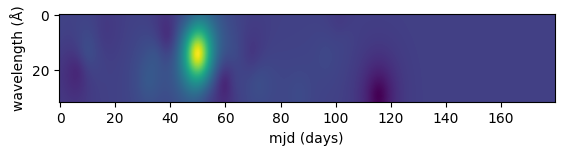

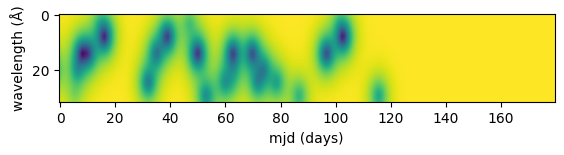

In [57]:
# Object that is not a Type 1a supernova
id = train_md_nonIa["object_id"].iloc[4]
obj = df.loc[df["object_id"] == id]
pred, uncertainties = create_heatmap(obj)
plt.figure(0)
plt.xlabel("mjd (days)")
plt.ylabel("wavelength (Å)")
plt.imshow(pred, cmap="viridis", interpolation="gaussian")
plt.figure(1)
plt.xlabel("mjd (days)")
plt.ylabel("wavelength (Å)")
plt.imshow(uncertainties, cmap="viridis", interpolation="gaussian")

#### Create heatmaps and labels for all data points

In [59]:
# Training data
train_ids = list(train_md_Ia["object_id"]) + list(train_md_nonIa["object_id"])
train_labels = [1]*len(train_md_Ia) + [0]*len(train_md_Ia)
shuffled_train_ids, shuffled_train_labels = shuffle(train_ids, train_labels, random_state=39)

train_data = [None]*len(shuffled_train_ids)
for i in range(len(shuffled_train_ids)):
    if i % 100 == 0:
        print("On iteration {}".format(i))
    id = shuffled_train_ids[i]
    pred, uncertainties = create_heatmap(df.loc[df["object_id"] == id])
    train_data[i] = np.dstack((pred, uncertainties))
train_data[0].shape

On iteration 0
On iteration 100
On iteration 200
On iteration 300
On iteration 400
On iteration 500
On iteration 600
On iteration 700
On iteration 800
On iteration 900
On iteration 1000
On iteration 1100
On iteration 1200
On iteration 1300
On iteration 1400
On iteration 1500
On iteration 1600
On iteration 1700
On iteration 1800
On iteration 1900
On iteration 2000
On iteration 2100
On iteration 2200
On iteration 2300
On iteration 2400
On iteration 2500
On iteration 2600
On iteration 2700
On iteration 2800
On iteration 2900
On iteration 3000
On iteration 3100
On iteration 3200
On iteration 3300
On iteration 3400
On iteration 3500
On iteration 3600


(32, 180, 2)

In [66]:
# Validation data
val_ids = list(val_md["object_id"])
val_labels = [0]*len(val_ids)
for i in range(len(val_ids)):
    id = val_ids[i]
    obj = val_md.loc[val_md["object_id"] == id]
    if obj.iloc[0]["target"] == 90:
        val_labels[i] = 1
shuffled_val_ids, shuffled_val_labels = shuffle(val_ids, val_labels, random_state=39)

val_data = [None]*len(shuffled_val_ids)
for i in range(len(shuffled_val_ids)):
    if i % 100 == 0:
        print("On iteration {}".format(i))
    id = shuffled_val_ids[i]
    pred, uncertainties = create_heatmap(df.loc[df["object_id"] == id])
    val_data[i] = np.dstack((pred, uncertainties))
val_data[0].shape

On iteration 0
On iteration 100
On iteration 200
On iteration 300
On iteration 400
On iteration 500
On iteration 600
On iteration 700


(32, 180, 2)

In [67]:
# Test data
test_ids = list(test_md["object_id"])
test_labels = [0]*len(test_ids)
for i in range(len(test_ids)):
    id = test_ids[i]
    obj = test_md.loc[test_md["object_id"] == id]
    if obj.iloc[0]["target"] == 90:
        test_labels[i] = 1
shuffled_test_ids, shuffled_test_labels = shuffle(test_ids, test_labels, random_state=39)

test_data = [None]*len(shuffled_test_ids)
for i in range(len(shuffled_test_ids)):
    if i % 100 == 0:
        print("On iteration {}".format(i))
    id = shuffled_test_ids[i]
    pred, uncertainties = create_heatmap(df.loc[df["object_id"] == id])
    test_data[i] = np.dstack((pred, uncertainties))
test_data[0].shape

On iteration 0
On iteration 100
On iteration 200
On iteration 300
On iteration 400
On iteration 500
On iteration 600
On iteration 700


(32, 180, 2)

In [70]:
# Save all arrays
np.save("train_ids", shuffled_train_ids)
np.save("train_data", train_data)
np.save("train_labels", shuffled_train_labels)
np.save("val_ids", shuffled_val_ids)
np.save("val_data", val_data)
np.save("val_labels", shuffled_val_labels)
np.save("test_ids", shuffled_test_ids)
np.save("test_data", test_data)
np.save("test_labels", shuffled_test_labels)